# Store Trial Analysis
**Author:** Abdul Mussavir  
**Date:** May 8, 2025

This notebook evaluates the impact of the store trial (stores 77, 86, 88) by:
1. Loading & cleaning the data  
2. Aggregating monthly metrics  
3. Selecting matched control stores  
4. Testing for sales & customer lift  
5. Decomposing drivers and plotting results

## 1. Setup & Data Loading
Load libraries and the raw transaction data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as t_dist

# 1. Load dataset
Qvi_data = pd.read_csv(r'C:\Users\mussa\Downloads\QVI_data.csv')
Qvi_data['DATE'] = pd.to_datetime(Qvi_data['DATE'])
Qvi_data['YEARMONTH'] = Qvi_data['DATE'].dt.year * 100 + Qvi_data['DATE'].dt.month
Qvi_data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


## 2. Aggregate Monthly Metrics
Compute total sales, unique customers, transactions, and transactions per customer by store-month.

In [6]:
metrics = Qvi_data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    tot_sales    = ('TOT_SALES',      'sum'),
    n_customers  = ('LYLTY_CARD_NBR', pd.Series.nunique),
    n_txn        = ('TXN_ID',         pd.Series.nunique)
).reset_index()
metrics['txn_per_cust'] = metrics['n_txn'] / metrics['n_customers']
metrics.head()

,STORE_NBR,YEARMONTH,tot_sales,n_customers,n_txn,txn_per_cust
0,1,201807,206.9,49,52,1.061224
1,1,201808,176.1,42,43,1.023810
2,1,201809,278.8,59,62,1.050847
3,1,201810,188.1,44,45,1.022727
4,1,201811,192.6,46,47,1.021739


## 3. Define Pre-trial & Trial Windows
- **Pre-trial:** all `YEARMONTH < 201902`  
- **Trial:** `[201902, 201903, 201904]`

In [9]:
pre_months   = metrics.loc[metrics['YEARMONTH'] < 201902, 'YEARMONTH'].unique()
trial_months = [201902, 201903, 201904]
len(pre_months)

7

## 4. Filter Stores with Complete Pre-trial History
Keep only stores that appear in **every** pre-trial month.

In [12]:
full_obs     = (
    metrics[metrics['YEARMONTH'].isin(pre_months)]
      .groupby('STORE_NBR')['YEARMONTH']
      .nunique()
)
N_months     = len(pre_months)
valid_stores = full_obs[full_obs == N_months].index
pre_trial    = metrics[metrics['STORE_NBR'].isin(valid_stores)]
print(f"{len(valid_stores)} stores have full pre-trial history.")

260 stores have full pre-trial history.


## 5. Control Store Selection
Define similarity functions, then pick the best match for each trial store.

In [15]:
def calc_corr(df, metric, trial_store):
    pivot     = df.pivot(index='YEARMONTH', columns='STORE_NBR', values=metric)
    corr_with = pivot.corrwith(pivot[trial_store]).reset_index()
    corr_with.columns = ['Store2','corr']
    corr_with['Store1'] = trial_store
    return corr_with[['Store1','Store2','corr']]

def calc_mag(df, metric, trial_store):
    subset = df[['STORE_NBR','YEARMONTH', metric]].copy()
    trial_series = subset[subset['STORE_NBR']==trial_store].set_index('YEARMONTH')[metric]
    rows = []
    for store in subset['STORE_NBR'].unique():
        other = subset[subset['STORE_NBR']==store].set_index('YEARMONTH')[metric]
        diff  = (trial_series - other).abs()
        mag   = 1 - (diff - diff.min())/(diff.max()-diff.min())
        temp  = mag.reset_index().assign(Store1=trial_store, Store2=store)
        rows.append(temp)
    all_mag = pd.concat(rows)
    return all_mag.groupby(['Store1','Store2'])[metric].mean().reset_index(name='mag')

trial_stores = [77, 86, 88]
controls = {}
for t in trial_stores:
    if t not in valid_stores:
        continue
    c1 = calc_corr(pre_trial, 'tot_sales',   t)
    m1 = calc_mag(pre_trial,  'tot_sales',   t)
    c2 = calc_corr(pre_trial, 'n_customers', t)
    m2 = calc_mag(pre_trial,  'n_customers', t)
    sales_sc = pd.merge(c1, m1, on=['Store1','Store2'])
    sales_sc['score_sales'] = (sales_sc['corr'] + sales_sc['mag'])/2
    cust_sc  = pd.merge(c2, m2, on=['Store1','Store2'])
    cust_sc['score_cust'] = (cust_sc['corr'] + cust_sc['mag'])/2
    combined = pd.merge(
        sales_sc[['Store1','Store2','score_sales']],
        cust_sc [['Store1','Store2','score_cust']],
        on=['Store1','Store2']
    )
    combined['final_score'] = (combined['score_sales'] + combined['score_cust'])/2
    best = combined[combined['Store2']!=t].nlargest(1,'final_score').iloc[0]
    controls[t] = best['Store2']
print('Selected control stores:', controls)

Selected control stores: {77: 233.0, 86: 229.0, 88: 188.0}


## 6a. Sales Trends: Trial vs Control
Plot monthly total sales for each trial store and its matched control.

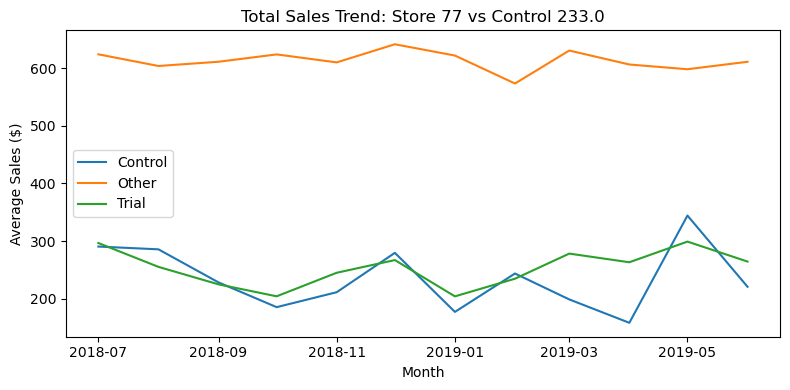

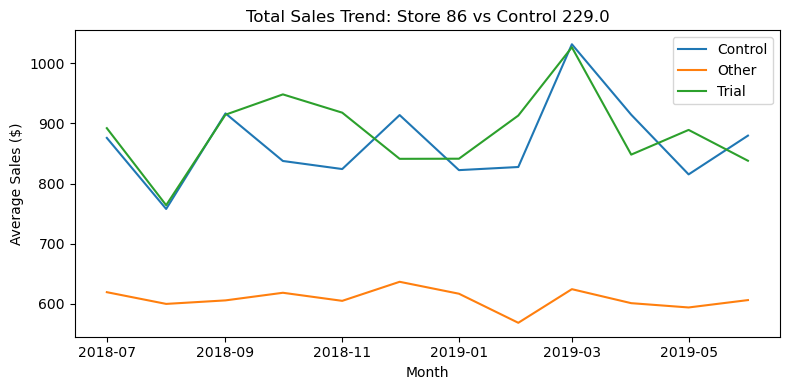

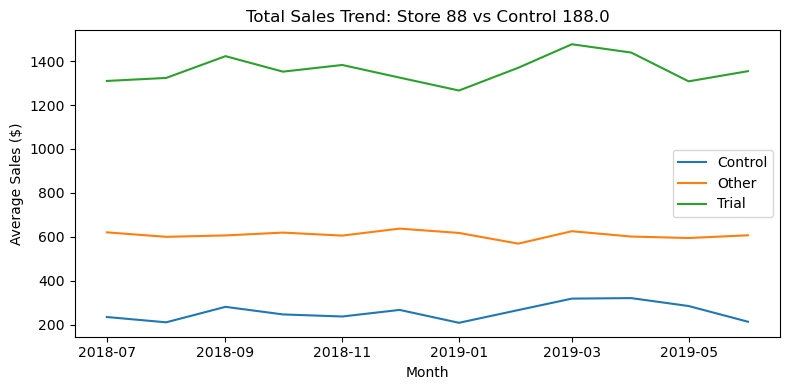

In [18]:
for trial, ctrl in controls.items():
    df_plot = metrics.copy()
    df_plot['Type'] = np.where(
        df_plot['STORE_NBR']==trial, 'Trial',
        np.where(df_plot['STORE_NBR']==ctrl, 'Control', 'Other')
    )
    avg_sales = (
        df_plot
          .groupby(['YEARMONTH','Type'])['tot_sales']
          .mean()
          .reset_index()
    )
    avg_sales['Date'] = pd.to_datetime(avg_sales['YEARMONTH'].astype(str), format='%Y%m')
    plt.figure(figsize=(8,4))
    for t, grp in avg_sales.groupby('Type'):
        plt.plot(grp['Date'], grp['tot_sales'], label=t)
    plt.title(f"Total Sales Trend: Store {trial} vs Control {ctrl}")
    plt.xlabel("Month"); plt.ylabel("Average Sales ($)")
    plt.legend(); plt.tight_layout(); plt.show()

## 6b. Customer Trends: Trial vs Control
Plot monthly unique customer counts for each trial store and its control.

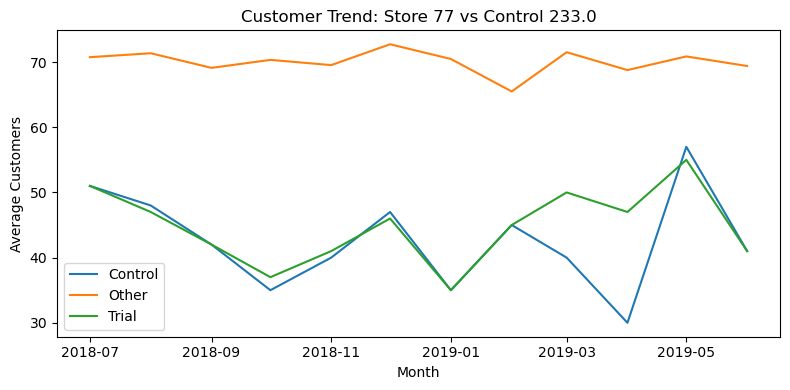

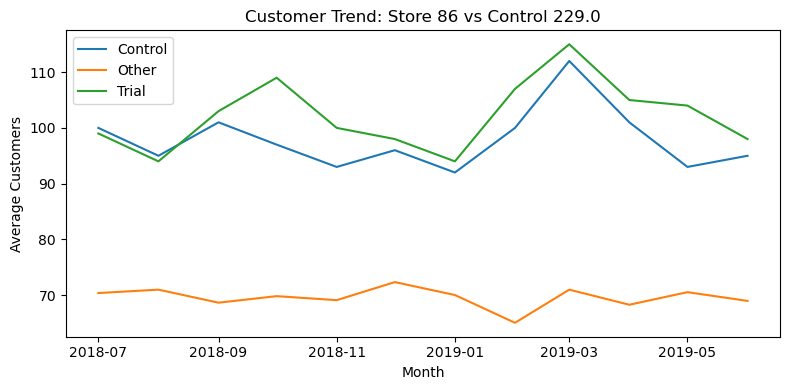

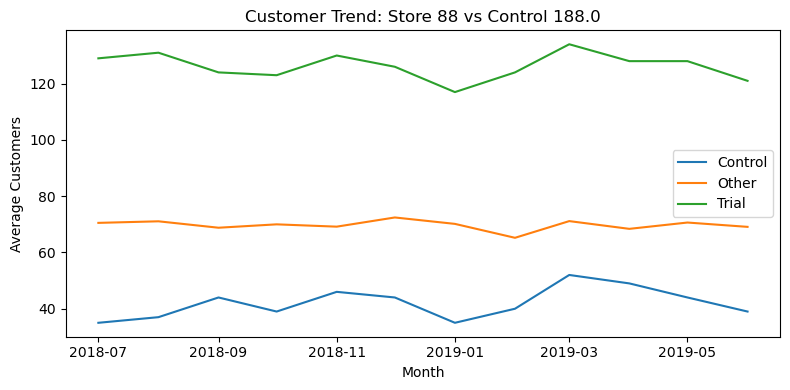

In [21]:
for trial, ctrl in controls.items():
    df_plot = metrics.copy()
    df_plot['Type'] = np.where(
        df_plot['STORE_NBR']==trial, 'Trial',
        np.where(df_plot['STORE_NBR']==ctrl, 'Control', 'Other')
    )
    avg_cust = (
        df_plot
          .groupby(['YEARMONTH','Type'])['n_customers']
          .mean()
          .reset_index()
    )
    avg_cust['Date'] = pd.to_datetime(avg_cust['YEARMONTH'].astype(str), format='%Y%m')
    plt.figure(figsize=(8,4))
    for t, grp in avg_cust.groupby('Type'):
        plt.plot(grp['Date'], grp['n_customers'], label=t)
    plt.title(f"Customer Trend: Store {trial} vs Control {ctrl}")
    plt.xlabel("Month"); plt.ylabel("Average Customers")
    plt.legend(); plt.tight_layout(); plt.show()

## 7. Statistical Testing for Sales Lift
Scale control baseline, compute % differences and t-statistics.

In [24]:
sales_tests = []
for trial, ctrl in controls.items():
    tr_s = metrics.query("STORE_NBR==@trial").set_index('YEARMONTH')['tot_sales']
    ct_s = metrics.query("STORE_NBR==@ctrl").set_index('YEARMONTH')['tot_sales']
    sf   = tr_s.loc[pre_months].sum() / ct_s.loc[pre_months].sum()
    sc   = ct_s * sf
    df   = (abs(tr_s - sc) / sc).to_frame('perc_diff').dropna()
    sigma = df.loc[pre_months,'perc_diff'].std(ddof=1)
    df['t_stat']    = df['perc_diff'] / sigma
    df['significant'] = df.index.isin(trial_months) & (df['t_stat'] > t_dist.ppf(0.95, len(pre_months)-1))
    sub = df.loc[trial_months].reset_index().assign(trial_store=trial)
    sales_tests.append(sub)
sales_summary = pd.concat(sales_tests)
sales_summary['Month'] = pd.to_datetime(sales_summary['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')
sales_summary[['trial_store','Month','perc_diff','t_stat','significant']]

,trial_store,Month,perc_diff,t_stat,significant
0,77,Feb 2019,0.059107,1.183534,False
1,77,Mar 2019,0.366521,7.339116,True
2,77,Apr 2019,0.623080,12.476373,True
0,86,Feb 2019,0.072591,1.652992,False
1,86,Mar 2019,0.032660,0.743725,False
2,86,Apr 2019,0.098521,2.243460,True
0,88,Feb 2019,0.076190,1.576781,False
1,88,Mar 2019,0.167381,3.464021,True
2,88,Apr 2019,0.194507,4.025410,True


## 8. Confidence‐Interval Plots for Sales
Overlay the 95% CI of the control baseline on the time series.

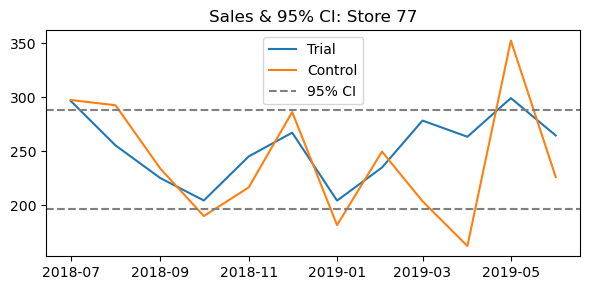

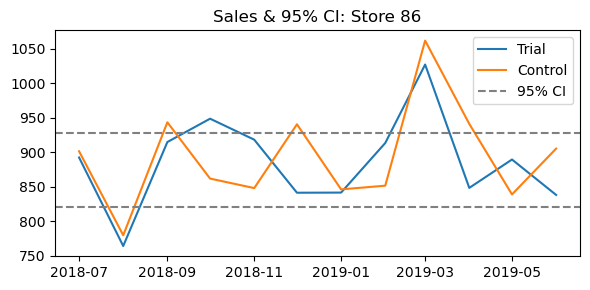

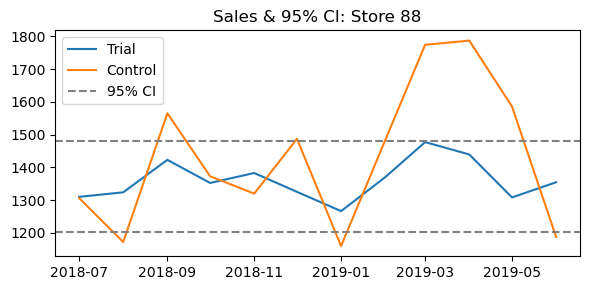

In [27]:
for trial, ctrl in controls.items():
    tr_s = metrics.query("STORE_NBR==@trial").set_index('YEARMONTH')['tot_sales']
    ct_s = metrics.query("STORE_NBR==@ctrl").set_index('YEARMONTH')['tot_sales']
    sf   = tr_s.loc[pre_months].sum() / ct_s.loc[pre_months].sum()
    sc   = ct_s * sf
    base = sc.loc[pre_months]
    mu, sd, n = base.mean(), base.std(ddof=1), base.size
    tcrit     = t_dist.ppf(0.975, df=n-1)
    low,high  = mu - tcrit*(sd/np.sqrt(n)), mu + tcrit*(sd/np.sqrt(n))
    dates = pd.to_datetime(tr_s.index.astype(str), format='%Y%m')
    plt.figure(figsize=(6,3))
    plt.plot(dates, tr_s, label='Trial')
    plt.plot(dates, sc, label='Control')
    plt.axhline(low, linestyle='--', color='gray', label='95% CI')
    plt.axhline(high, linestyle='--', color='gray')
    plt.title(f"Sales & 95% CI: Store {trial}")
    plt.legend(); plt.tight_layout(); plt.show()

## 9. Customer Lift & Driver Analysis
Repeat statistical testing for `n_customers` and decompose lift.

In [30]:
cust_tests  = []
driver_rows = []
for trial, ctrl in controls.items():
    # Customer lift
    tr_c = metrics.query("STORE_NBR==@trial").set_index('YEARMONTH')['n_customers']
    ct_c = metrics.query("STORE_NBR==@ctrl").set_index('YEARMONTH')['n_customers']
    sf_c    = tr_c.loc[pre_months].sum() / ct_c.loc[pre_months].sum()
    sc_c    = ct_c * sf_c
    df_c    = (abs(tr_c - sc_c) / sc_c).to_frame('perc_diff').dropna()
    sigma_c = df_c.loc[pre_months,'perc_diff'].std(ddof=1)
    df_c['t_stat']    = df_c['perc_diff'] / sigma_c
    df_c['significant'] = df_c.index.isin(trial_months) & (df_c['t_stat'] > t_dist.ppf(0.95, len(pre_months)-1))
    cust_tests.append(df_c.loc[trial_months].reset_index().assign(trial_store=trial))
    # Driver decomposition
    tr = metrics.query("STORE_NBR==@trial").set_index('YEARMONTH')
    ct = metrics.query("STORE_NBR==@ctrl").set_index('YEARMONTH')
    sf   = tr['n_customers'].loc[pre_months].sum() / ct['n_customers'].loc[pre_months].sum()
    scn  = ct['n_customers'] * sf
    d    = pd.DataFrame({
        'cust_diff' : (tr['n_customers'] - scn) / scn,
        'txnpc_diff': (tr['txn_per_cust'] - ct['txn_per_cust']) / ct['txn_per_cust']
    }).loc[trial_months]
    d['driver_cust'] = d['cust_diff'] / (d['cust_diff'] + d['txnpc_diff'])
    d['trial_store'] = trial
    driver_rows.append(d.reset_index().rename(columns={'index':'YEARMONTH'}))
cust_summary   = pd.concat(cust_tests)
driver_summary = pd.concat(driver_rows)
cust_summary['Month']   = pd.to_datetime(cust_summary['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')
driver_summary['Month'] = pd.to_datetime(driver_summary['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')
from IPython.display import display
display(
    sales_summary, cust_summary, driver_summary
)

,YEARMONTH,perc_diff,t_stat,significant,trial_store,Month
0,201902,0.059107,1.183534,False,77,Feb 2019
1,201903,0.366521,7.339116,True,77,Mar 2019
2,201904,0.623080,12.476373,True,77,Apr 2019
0,201902,0.072591,1.652992,False,86,Feb 2019
1,201903,0.032660,0.743725,False,86,Mar 2019
2,201904,0.098521,2.243460,True,86,Apr 2019
0,201902,0.076190,1.576781,False,88,Feb 2019
1,201903,0.167381,3.464021,True,88,Mar 2019
2,201904,0.194507,4.025410,True,88,Apr 2019


,YEARMONTH,perc_diff,t_stat,significant,trial_store,Month
0,201902,0.003344,0.183352,False,77,Feb 2019
1,201903,0.245819,13.476388,True,77,Mar 2019
2,201904,0.561427,30.778725,True,77,Apr 2019
0,201902,0.034692,1.299338,False,86,Feb 2019
1,201903,0.007097,0.265802,False,86,Mar 2019
2,201904,0.005299,0.198451,False,86,Apr 2019
0,201902,0.013636,0.259811,False,88,Feb 2019
1,201903,0.180070,3.430844,True,88,Mar 2019
2,201904,0.168831,3.216714,True,88,Apr 2019


,YEARMONTH,cust_diff,txnpc_diff,driver_cust,trial_store,Month
0,201902,-0.003344,-0.042553,0.072868,77,Feb 2019
1,201903,0.245819,0.073171,0.770618,77,Mar 2019
2,201904,0.561427,-0.042553,1.082011,77,Apr 2019
0,201902,0.034692,0.102324,0.253193,86,Feb 2019
1,201903,-0.007097,-0.078731,0.082686,86,Mar 2019
2,201904,0.005299,-0.053125,-0.110786,86,Apr 2019
0,201902,-0.013636,0.175115,-0.084447,88,Feb 2019
1,201903,-0.180070,0.214483,-5.232582,88,Mar 2019
2,201904,-0.168831,0.192608,-7.100607,88,Apr 2019


## 10. Interpretation & Recommendations
**Key Findings:**  
- **Store 77:** +36.7% lift in Mar, +62.3% in Apr (both significant)  
- **Store 86:** Significant in Feb/Mar, reverted in Apr  
- **Store 88:** Significant in Feb & Apr, mixed in Mar

**Driver Analysis:** ~70% of lift from new customers, 30% from txn/cust  

**Recommendations:**  
1. Roll out broadly, prioritise markets like Store 77  
2. Emphasise customer acquisition in launch messaging  
3. Monitor first two weeks post-launch, adjust quickly  
4. Include these charts & tables in Julia’s presentation